In [1]:
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Model Storage Path**

In [4]:
model_path = '/content/drive/MyDrive/UIElements/mini/mini/model/mask.h5'


**Load Dataset**

In [6]:
TRAINING_DIR = "/content/drive/MyDrive/mini/train/train"
TEST_DIR = "/content/drive/MyDrive/mini/test/test"


**Split Data**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.1,  # 10% for validation
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 1185 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 194 images belonging to 2 classes.


**Model**

In [5]:
model = Sequential([
    Conv2D(256, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 984064)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 984064)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   125,960,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,557,826 (482.78 MB)

 Trainable params: 126,557,826 (482.78 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn import metrics


checkpoint = ModelCheckpoint(model_path,monitor='val_loss',verbose=1,save_best_only=True,mode='auto')

# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


history = model.fit(train_generator,
                              epochs=100,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

test_generator.reset()
predictions = np.argmax(model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

# Metrics
accuracy = accuracy_score(true_labels, predictions)
print("Face Recognition Accuracy:", accuracy)

precision_scores = precision_score(true_labels, predictions, average=None)
print("Precision per class:", precision_scores)
print("Mean Precision:", precision_scores.mean())

recall_scores = recall_score(true_labels, predictions, average=None)
print("Recall per class:", recall_scores)
print("Mean Recall:", recall_scores.mean())

f1_scores = f1_score(true_labels, predictions, average=None)
print("F1 Score per class:", f1_scores)
print("Mean F1 Score:", f1_scores.mean())


print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5093 - loss: 1.5105
Epoch 1: val_loss improved from inf to 0.66092, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 357s 9s/step - accuracy: 0.5099 - loss: 1.4980 - val_accuracy: 0.5154 - val_loss: 0.6609
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6708 - loss: 0.5989
Epoch 2: val_loss improved from 0.66092 to 0.52282, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6724 - loss: 0.5975 - val_accuracy: 0.7462 - val_loss: 0.5228
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7732 - loss: 0.4983
Epoch 3: val_loss improved from 0.52282 to 0.31662, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7744 - loss: 0.4961 - val_accuracy: 0.8846 - val_loss: 0.3166
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8726 - loss: 0.3190
Epoch 4: val_loss improved from 0.31662 to 0.28560, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8726 - loss: 0.3188 - val_accuracy: 0.8923 - val_loss: 0.2856
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8881 - loss: 0.2785
Epoch 5: val_loss did not improve from 0.28560
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8879 - loss: 0.2792 - val_accuracy: 0.8923 - val_loss: 0.3155
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8910 - loss: 0.2848
Epoch 6: val_loss did not improve from 0.28560
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 843ms/step - accuracy: 0.8911 - loss: 0.2846 - val_accuracy: 0.8769 - val_loss: 0.3003
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8956 - loss: 0.2655
Epoch 7: val_loss improved from 0.28560 to 0.24773, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8959 - loss: 0.2653 - val_accuracy: 0.9000 - val_loss: 0.2477
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9153 - loss: 0.2396
Epoch 8: val_loss improved from 0.24773 to 0.23112, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9153 - loss: 0.2394 - val_accuracy: 0.9154 - val_loss: 0.2311
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.8981 - loss: 0.2664
Epoch 9: val_loss did not improve from 0.23112
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 868ms/step - accuracy: 0.8978 - loss: 0.2671 - val_accuracy: 0.9077 - val_loss: 0.2798
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.9075 - loss: 0.2337
Epoch 10: val_loss improved from 0.23112 to 0.21262, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9076 - loss: 0.2335 - val_accuracy: 0.9385 - val_loss: 0.2126
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.9209 - loss: 0.2265
Epoch 11: val_loss did not improve from 0.21262
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 982ms/step - accuracy: 0.9209 - loss: 0.2262 - val_accuracy: 0.9077 - val_loss: 0.2305
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9303 - loss: 0.1947
Epoch 12: val_loss did not improve from 0.21262
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 832ms/step - accuracy: 0.9302 - loss: 0.1948 - val_accuracy: 0.8923 - val_loss: 0.2384
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.9364 - loss: 0.1888
Epoch 13: val_loss improved from 0.21262 to 0.20537, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9362 - loss: 0.1891 - val_accuracy: 0.9308 - val_loss: 0.2054
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9357 - loss: 0.1669
Epoch 14: val_loss improved from 0.20537 to 0.15962, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9357 - loss: 0.1674 - val_accuracy: 0.9538 - val_loss: 0.1596
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9458 - loss: 0.1487
Epoch 15: val_loss did not improve from 0.15962
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9457 - loss: 0.1492 - val_accuracy: 0.9154 - val_loss: 0.1913
Epoch 16/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9208 - loss: 0.2161
Epoch 16: val_loss improved from 0.15962 to 0.12433, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9212 - loss: 0.2154 - val_accuracy: 0.9692 - val_loss: 0.1243
Epoch 17/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9350 - loss: 0.1801
Epoch 17: val_loss did not improve from 0.12433
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9351 - loss: 0.1798 - val_accuracy: 0.9308 - val_loss: 0.1889
Epoch 18/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.8200 - loss: 0.4208
Epoch 18: val_loss did not improve from 0.12433
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 853ms/step - accuracy: 0.8210 - loss: 0.4186 - val_accuracy: 0.8846 - val_loss: 0.2812
Epoch 19/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.9137 - loss: 0.2073
Epoch 19: val_loss did not improve from 0.12433
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 849ms/step - accuracy: 0.9140 - loss: 0.2070 - val_accuracy: 0.8769 - val_loss: 0.3151
Epoch 20/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.9148 - loss: 0.2490
Epoch 20: val_loss did not improve from 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9434 - loss: 0.1495 - val_accuracy: 0.9692 - val_loss: 0.1072
Epoch 30/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9361 - loss: 0.1686
Epoch 30: val_loss did not improve from 0.10725
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9363 - loss: 0.1680 - val_accuracy: 0.9231 - val_loss: 0.1895
Epoch 31/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9440 - loss: 0.1528
Epoch 31: val_loss did not improve from 0.10725
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 835ms/step - accuracy: 0.9441 - loss: 0.1524 - val_accuracy: 0.9385 - val_loss: 0.2156
Epoch 32/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9418 - loss: 0.1411
Epoch 32: val_loss did not improve from 0.10725
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - accuracy: 0.9418 - loss: 0.1414 - val_accuracy: 0.9462 - val_loss: 0.1474
Epoch 33/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9356 - loss: 0.2021
Epoch 33: val_loss did not improve from 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9664 - loss: 0.1012 - val_accuracy: 0.9615 - val_loss: 0.0972
Epoch 41/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9561 - loss: 0.1058
Epoch 41: val_loss did not improve from 0.09722
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 940ms/step - accuracy: 0.9562 - loss: 0.1060 - val_accuracy: 0.9462 - val_loss: 0.1427
Epoch 42/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.9593 - loss: 0.1212
Epoch 42: val_loss improved from 0.09722 to 0.09198, saving model to /content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9593 - loss: 0.1210 - val_accuracy: 0.9692 - val_loss: 0.0920
Epoch 43/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9571 - loss: 0.1141
Epoch 43: val_loss did not improve from 0.09198
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9571 - loss: 0.1138 - val_accuracy: 0.9692 - val_loss: 0.0967
Epoch 44/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.9714 - loss: 0.0835
Epoch 44: val_loss did not improve from 0.09198
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 844ms/step - accuracy: 0.9714 - loss: 0.0836 - val_accuracy: 0.9615 - val_loss: 0.1076
Epoch 45/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.9652 - loss: 0.1061
Epoch 45: val_loss did not improve from 0.09198
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 833ms/step - accuracy: 0.9652 - loss: 0.1058 - val_accuracy: 0.9692 - val_loss: 0.1058
Epoch 46/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.9733 - loss: 0.0795
Epoch 46: val_loss did not improve from 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9672 - loss: 0.0990 - val_accuracy: 0.9769 - val_loss: 0.0830
Epoch 53/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.9694 - loss: 0.0992
Epoch 53: val_loss did not improve from 0.08297
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 980ms/step - accuracy: 0.9694 - loss: 0.0991 - val_accuracy: 0.9538 - val_loss: 0.1504
Epoch 54/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9692 - loss: 0.0951
Epoch 54: val_loss did not improve from 0.08297
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 813ms/step - accuracy: 0.9692 - loss: 0.0952 - val_accuracy: 0.9538 - val_loss: 0.1387
Epoch 55/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9685 - loss: 0.1021
Epoch 55: val_loss did not improve from 0.08297
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 856ms/step - accuracy: 0.9684 - loss: 0.1019 - val_accuracy: 0.9538 - val_loss: 0.1277
Epoch 56/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9737 - loss: 0.0759
Epoch 56: val_loss did not improve 

38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9808 - loss: 0.0528 - val_accuracy: 0.9769 - val_loss: 0.0667
Epoch 71/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9761 - loss: 0.0600
Epoch 71: val_loss did not improve from 0.06671
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 910ms/step - accuracy: 0.9761 - loss: 0.0601 - val_accuracy: 0.9692 - val_loss: 0.0865
Epoch 72/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.9812 - loss: 0.0619
Epoch 72: val_loss did not improve from 0.06671
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 863ms/step - accuracy: 0.9812 - loss: 0.0620 - val_accuracy: 0.9615 - val_loss: 0.0895
Epoch 73/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9760 - loss: 0.0760
Epoch 73: val_loss did not improve from 0.06671
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 828ms/step - accuracy: 0.9760 - loss: 0.0759 - val_accuracy: 0.9692 - val_loss: 0.0864
Epoch 74/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.9761 - loss: 0.0627
Epoch 74: val_loss did not improve 

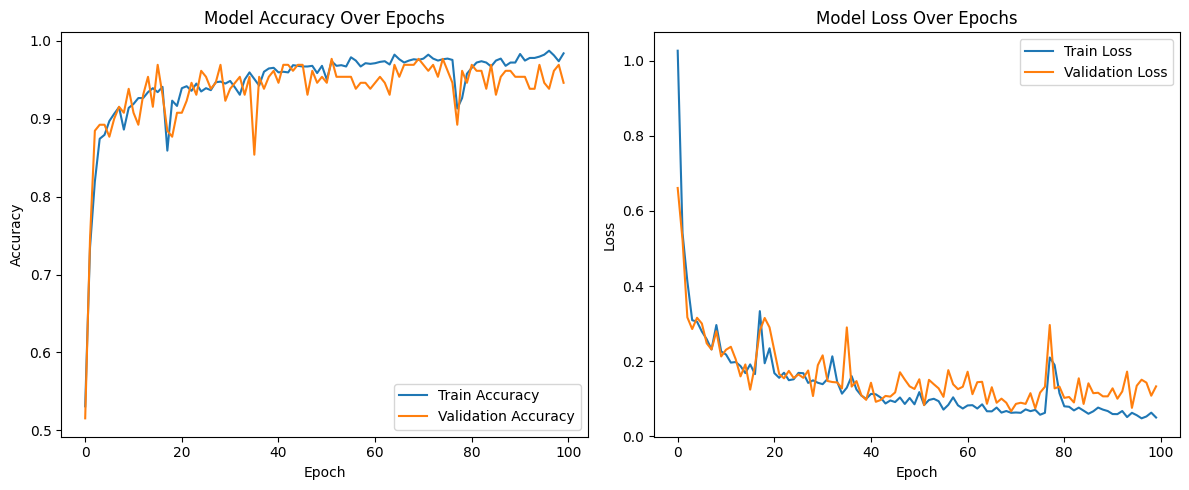

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy and Confusion matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step
Test Accuracy: 0.979381443298969
Precision: [0.96039604 1.        ]
Recall: [1.         0.95876289]
F1 Score: [0.97979798 0.97894737]
Classification Report:
               precision    recall  f1-score   support

   with_mask       0.96      1.00      0.98        97
without_mask       1.00      0.96      0.98        97

    accuracy                           0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194



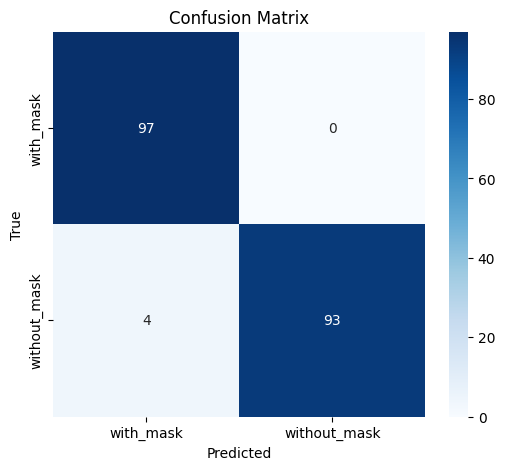

In [13]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
model = load_model('/content/drive/MyDrive/UIElements/mini/mini/model/finalmask1.h5')

# Predict on test data
test_generator.reset()
predictions = np.argmax(model.predict(test_generator), axis=-1)

# True labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
print("Test Accuracy:", accuracy)

precision = precision_score(true_labels, predictions, average=None)
recall = recall_score(true_labels, predictions, average=None)
f1 = f1_score(true_labels, predictions, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report(true_labels, predictions, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
